# Creating FAO Agro Maps per crop

This notebook uses input data from <a href="http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1026341/">FAO Agro Maps</a>. The scope is to extract all crops available at the desired resolution (admin level 2) merge with spatial admin layer and produce output that can later on be used in the downscaling process.

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br />
**Funding:** The World Bank (contract number: 7190531), [KTH](https://www.kth.se/en/itm/inst/energiteknik/forskning/desa/welcome-to-the-unit-of-energy-systems-analysis-kth-desa-1.197296)

In [1]:
# Import necessary modules and libraries

# Part 1
import pandas as pd
import os

# Part 2
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point, Polygon
%matplotlib inline

## Part 1. Creating csv files per crop

In [2]:
# Import agricultural data from MAPSPAM (https://www.mapspam.info/data/)
# STEP1: read in csv file version 

path= 
path = r"C:\Oluchi\Benin\ben_FAO_DATA"
name_of_file = "ben_all_data.csv"

In [3]:
# Import csv as pandas dataframe
df = pd.read_csv(path + "\\" + name_of_file)
df = df.drop(["CONTINENT_CODE", "CONTINENT_NAME"], axis=1)

In [5]:
df.head()

COUNTRY_CODE COUNTRY_NAME  AREA_CODE  AREA_NAME  ADMIN_LEVEL  ITEM_CODE  \
0          BEN        Benin  BEN001001  Banikoara            2        116   
1          BEN        Benin  BEN001001  Banikoara            2        116   
2          BEN        Benin  BEN001001  Banikoara            2        116   
3          BEN        Benin  BEN001001  Banikoara            2        116   
4          BEN        Benin  BEN001001  Banikoara            2        116   

  ITEM_NAME  YEAR  AEREA_HARVESTED  YIELD  PRODUCTION  
0  Potatoes  2001              NaN    NaN         NaN  
1  Potatoes  2002              NaN    NaN         NaN  
2  Potatoes  2003              NaN    NaN         NaN  
3  Potatoes  2004              NaN    NaN         NaN  
4  Potatoes  2005              NaN    NaN         NaN

In [4]:
print ("The number of administrative areas (level 2) is {}, as shown below:".format(df.AREA_NAME.nunique()))
df.AREA_NAME.unique()

The number of administrative areas (level 2) is 73, as shown below:


array(['Banikoara', 'Gogounou', 'Kandi', 'Karimama', 'Malanville',
       'Segbana', 'Boukoumbe', 'Kerou', 'Cobli', 'Kouande', 'Materi',
       'Natingou', 'Pehonko', 'Tanguieta', 'Tchoukoutouna',
       'Abomey-Calavi', 'Allada', 'Kpomasse', 'Ouidah', 'So-Ava', 'Toffo',
       'Tori-Bossito', 'Ze', 'Bembereke', 'Kalale', 'Ndali', 'Nikki',
       'Parakou', 'Perere', 'Sinende', 'Bante', 'Dassa', 'Glazoue',
       'Ouesse', 'Savalou', 'Save', 'Aplahoue', 'Djakotome', 'Dogbo-Tota',
       'Klouekanme', 'Lalo', 'Toviklin', 'Copargo', 'Ouake', 'Cotonou',
       'Athieme', 'Bopa', 'Come', 'Grand-Popo', 'Houeyogbe', 'Adjarra',
       'Adjohoun', 'Aguegue', 'Akpro-Misserete', 'Avrankou', 'Bonou',
       'Dangbo', 'Porto Novo', 'Seme-Kpodji', 'Ikpinle (Adja-Oue',
       'Ifangni', 'Ketou', 'Pobe', 'Sakete', 'Abomey', 'Agbangnizoun',
       'Bohicon', 'Cove', 'Djidja', 'Ouinhi', 'Za Kpota', 'Zangnanado',
       'Zogbodome'], dtype=object)

<div class="alert alert-block alert-warning">
<b>Note_1:</b> According to the <a href="http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1026341/">data source</a> the most recent year for which admin level 2 data for harvested area are availavle, is the year 2000. 
</div>

In [5]:
print ("The number of crops is {}, as shown below:".format(df.ITEM_NAME.nunique()))
df.ITEM_NAME.unique()

The number of crops is 27, as shown below:


array(['Potatoes', 'Sweet Potatoes', 'Cassava', 'Taro (Coco Yam)', 'Yams',
       'Sugar Cane', 'Broad Beans, Dry', 'Cow Peas, Dry', 'Bambara Beans',
       'Soybeans', 'Groundnuts in Shell', 'Rice, Paddy', 'Sesame Seed',
       'Seed Cotton', 'Tomatoes', 'Chillies&Peppers, Green',
       'Onions, Dry', 'Okra', 'Maize', 'Watermelons', 'Pineapples',
       'Pimento, Allspice', 'Millet', 'Tobacco Leaves', 'Sorghum',
       'Fonio', 'Pigeon Peas'], dtype=object)

<div class="alert alert-block alert-warning">
<b>Note_2:</b> According to the <a href="http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1026341/">data source</a> the crops for which admin level 2 data for harvested area are availavle include Maize, Cassava, Dry Beans and Rice Paddy. Therefore we only focus on these crops.
</div>

### Extracting crop data per admin 2 to unique datarames

#### Maize

In [6]:
# Select crop and data as per availability
df_maize_2000_admin2 = df[(df['AEREA_HARVESTED'].notnull()) & 
                          (df['AEREA_HARVESTED'] > 0) &
                          (df['ITEM_NAME'] == "Maize") & 
                          (df['YEAR'] == "2000") &
                          (df['ADMIN_LEVEL'] == 2)]

# Calculate total harvested area
Maize_harv_area_ha_2000 = df_maize_2000_admin2["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Maize under the selected parameters is:", Maize_harv_area_ha_2000, "ha")

# Other stats on the dataset
df_maize_2000_admin2.describe()

Total harvested area for Maize under the selected parameters is: 628930.0 ha


ADMIN_LEVEL  ITEM_CODE  AEREA_HARVESTED      YIELD    PRODUCTION
count         73.0       73.0        73.000000  73.000000     73.000000
mean           2.0       56.0      8615.479452   1.127080   9913.424658
std            0.0        0.0      9461.808958   0.426544  12043.929366
min            2.0       56.0         3.000000   0.333000      1.000000
25%            2.0       56.0      2596.000000   0.861000   2912.000000
50%            2.0       56.0      6180.000000   1.027000   5983.000000
75%            2.0       56.0     11215.000000   1.301000  11360.000000
max            2.0       56.0     53090.000000   3.088000  69059.000000

In [7]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_maize_2000_admin2["Admin_2_share"] = df_maize_2000_admin2["AEREA_HARVESTED"] / Maize_harv_area_ha_2000

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [8]:
# This is the value retrieved from the source
Maize_harv_area_ha_2018 = 1157805

df_maize_2000_admin2["Area_Harv_2018"] = df_maize_2000_admin2["Admin_2_share"] * Maize_harv_area_ha_2018

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
df_maize_2000_admin2

COUNTRY_CODE COUNTRY_NAME  AREA_CODE   AREA_NAME  ADMIN_LEVEL  \
231            BEN        Benin  BEN001001   Banikoara            2   
536            BEN        Benin  BEN001002    Gogounou            2   
837            BEN        Benin  BEN001003       Kandi            2   
1131           BEN        Benin  BEN001004    Karimama            2   
1433           BEN        Benin  BEN001005  Malanville            2   
...            ...          ...        ...         ...          ...   
19894          BEN        Benin  BEN012005      Djidja            2   
20204          BEN        Benin  BEN012006      Ouinhi            2   
20509          BEN        Benin  BEN012007    Za Kpota            2   
20828          BEN        Benin  BEN012008  Zangnanado            2   
21144          BEN        Benin  BEN012009   Zogbodome            2   

       ITEM_CODE ITEM_NAME  YEAR  AEREA_HARVESTED    YIELD  PRODUCTION  \
231           56     Maize  2000          11964.0  1.10300     13197.0   
536           56     Maize  2000           6677.0  1.51000     10083.0   
837           56     Maize  2000          19803.0  1.90300     37691.0   
1131          56     Maize  2000           1250.0  0.90899      1136.0   
1433          56     Maize  2000           4615.0  1.09200      5041.0   
...          ...       ...   ...              ...      ...         ...   
19894         56     Maize  2000           8512.0  0.80000      6807.0   
20204         56     Maize  2000           3429.0  0.77600      2662.0   
20509         56     Maize  2000           7433.0  0.84399      6277.0   
20828         56     Maize  2000           2596.0  0.76999      1999.0   
21144         56     Maize  2000           4162.0  0.73299      3051.0   

       Admin_2_share  Area_Harv_2018  
231         0.019023    22024.675274  
536         0.010616    12291.771715  
837         0.031487    36455.587132  
1131        0.001988     2301.140429  
1433        0.007338     8495.810464  
...              ...             ...  
19894       0.013534    15669.845865  
20204       0.005452     6312.488425  
20509       0.011818    13683.501447  
20828       0.004128     4779.008443  
21144       0.006618     7661.877172  

[73 rows x 13 columns]

#### Cassava

In [10]:
df_cassava_2000_admin2 = df[(df['AEREA_HARVESTED'].notnull()) & 
                          (df['AEREA_HARVESTED'] > 0) &
                          (df['ITEM_NAME'] == "Cassava") & 
                          (df['YEAR'] == "2000")&
                          (df['ADMIN_LEVEL'] == 2)]

# Calculate total harvested area
Cassava_harv_area_ha_2000 = df_cassava_2000_admin2["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Cassava under the selected parameters is:", Cassava_harv_area_ha_2000, "ha")

# Other stats on the dataset
df_cassava_2000_admin2.describe()

Total harvested area for Cassava under the selected parameters is: 202788.0 ha


ADMIN_LEVEL  ITEM_CODE  AEREA_HARVESTED      YIELD     PRODUCTION
count         72.0       72.0        72.000000  72.000000      72.000000
mean           2.0      125.0      2816.500000  10.185986   29923.680556
std            0.0        0.0      4011.352296   4.859656   45134.090286
min            2.0      125.0         2.000000   3.990000      10.000000
25%            2.0      125.0       511.000000   6.964500    3550.250000
50%            2.0      125.0      1388.500000   8.924500   14792.000000
75%            2.0      125.0      3052.250000  12.717000   33040.000000
max            2.0      125.0     23556.000000  27.763000  248876.000000

In [11]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_cassava_2000_admin2["Admin_2_share"] = df_cassava_2000_admin2["AEREA_HARVESTED"] / Cassava_harv_area_ha_2000

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [12]:
# This is the value retrieved from the source
Cassava_harv_area_ha_2018 = 280810

df_cassava_2000_admin2["Area_Harv_2018"] = df_cassava_2000_admin2["Admin_2_share"] * Cassava_harv_area_ha_2018

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
df_cassava_2000_admin2

COUNTRY_CODE COUNTRY_NAME  AREA_CODE   AREA_NAME  ADMIN_LEVEL  \
30             BEN        Benin  BEN001001   Banikoara            2   
340            BEN        Benin  BEN001002    Gogounou            2   
645            BEN        Benin  BEN001003       Kandi            2   
940            BEN        Benin  BEN001004    Karimama            2   
1237           BEN        Benin  BEN001005  Malanville            2   
...            ...          ...        ...         ...          ...   
19684          BEN        Benin  BEN012005      Djidja            2   
19998          BEN        Benin  BEN012006      Ouinhi            2   
20306          BEN        Benin  BEN012007    Za Kpota            2   
20617          BEN        Benin  BEN012008  Zangnanado            2   
20930          BEN        Benin  BEN012009   Zogbodome            2   

       ITEM_CODE ITEM_NAME  YEAR  AEREA_HARVESTED   YIELD  PRODUCTION  \
30           125   Cassava  2000            453.0   5.000      2265.0   
340          125   Cassava  2000            130.0   6.723       874.0   
645          125   Cassava  2000            654.0   4.650      3041.0   
940          125   Cassava  2000            120.0   6.467       776.0   
1237         125   Cassava  2000            113.0   6.080       687.0   
...          ...       ...   ...              ...     ...         ...   
19684        125   Cassava  2000           2455.0   9.512     23351.0   
19998        125   Cassava  2000           3395.0   5.770     19588.0   
20306        125   Cassava  2000           1295.0   6.111      7914.0   
20617        125   Cassava  2000           1942.0   5.908     11474.0   
20930        125   Cassava  2000           3188.0  13.205     42098.0   

       Admin_2_share  Area_Harv_2018  
30          0.002234      627.290224  
340         0.000641      180.017062  
645         0.003225      905.624297  
940         0.000592      166.169596  
1237        0.000557      156.476369  
...              ...             ...  
19684       0.012106     3399.552981  
19998       0.016742     4701.214815  
20306       0.006386     1793.246888  
20617       0.009577     2689.177959  
20930       0.015721     4414.572263  

[72 rows x 13 columns]

#### Yam

In [14]:
df_yams_2000_admin2 = df[(df['AEREA_HARVESTED'].notnull()) & 
                          (df['AEREA_HARVESTED'] > 0) &
                          (df['ITEM_NAME'] == "Yams") & 
                          (df['YEAR'] == "2000")&
                          (df['ADMIN_LEVEL'] == 2)]

# Calculate total harvested area
yams_harv_area_ha_2000 = df_yams_2000_admin2["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Yams under the selected parameters is:", yams_harv_area_ha_2000, "ha")

# Other stats on the dataset
df_yams_2000_admin2.describe()

Total harvested area for Yams under the selected parameters is: 134666.0 ha


ADMIN_LEVEL  ITEM_CODE  AEREA_HARVESTED      YIELD     PRODUCTION
count         45.0       45.0        45.000000  45.000000      45.000000
mean           2.0      137.0      2992.577778  10.521733   32281.355556
std            0.0        0.0      3000.094260   3.870496   35162.967418
min            2.0      137.0         1.000000   0.850000       7.000000
25%            2.0      137.0       115.000000   7.700000     750.000000
50%            2.0      137.0      1844.000000  10.462000   24462.000000
75%            2.0      137.0      4942.000000  13.500000   48960.000000
max            2.0      137.0     11232.000000  17.600000  134784.000000

In [15]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_yams_2000_admin2["Admin_2_share"] = df_yams_2000_admin2["AEREA_HARVESTED"] / yams_harv_area_ha_2000

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [16]:
# This is the value retrieved from the source
yams_harv_area_ha_2018 = 216592

df_yams_2000_admin2["Area_Harv_2018"] = df_yams_2000_admin2["Admin_2_share"] * yams_harv_area_ha_2018

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
df_yams_2000_admin2

COUNTRY_CODE COUNTRY_NAME  AREA_CODE          AREA_NAME  ADMIN_LEVEL  \
55             BEN        Benin  BEN001001          Banikoara            2   
365            BEN        Benin  BEN001002           Gogounou            2   
670            BEN        Benin  BEN001003              Kandi            2   
1883           BEN        Benin  BEN002001          Boukoumbe            2   
2177           BEN        Benin  BEN002002              Kerou            2   
2465           BEN        Benin  BEN002003              Cobli            2   
2756           BEN        Benin  BEN002004            Kouande            2   
3042           BEN        Benin  BEN002005             Materi            2   
3336           BEN        Benin  BEN002006           Natingou            2   
3624           BEN        Benin  BEN002007            Pehonko            2   
3912           BEN        Benin  BEN002008          Tanguieta            2   
4204           BEN        Benin  BEN002009      Tchoukoutouna            2   
6660           BEN        Benin  BEN004001          Bembereke            2   
6955           BEN        Benin  BEN004002             Kalale            2   
7246           BEN        Benin  BEN004003              Ndali            2   
7545           BEN        Benin  BEN004004              Nikki            2   
7845           BEN        Benin  BEN004005            Parakou            2   
8142           BEN        Benin  BEN004006             Perere            2   
8442           BEN        Benin  BEN004007            Sinende            2   
8757           BEN        Benin  BEN005001              Bante            2   
9067           BEN        Benin  BEN005002              Dassa            2   
9380           BEN        Benin  BEN005003            Glazoue            2   
9693           BEN        Benin  BEN005004             Ouesse            2   
10009          BEN        Benin  BEN005005            Savalou            2   
10319          BEN        Benin  BEN005006               Save            2   
10635          BEN        Benin  BEN006001           Aplahoue            2   
11220          BEN        Benin  BEN006003         Dogbo-Tota            2   
11806          BEN        Benin  BEN006005               Lalo            2   
12395          BEN        Benin  BEN007003            Copargo            2   
12683          BEN        Benin  BEN007004              Ouake            2   
14912          BEN        Benin  BEN010002           Adjohoun            2   
15985          BEN        Benin  BEN010006              Bonou            2   
17071          BEN        Benin  BEN011001  Ikpinle (Adja-Oue            2   
17351          BEN        Benin  BEN011002            Ifangni            2   
17627          BEN        Benin  BEN011003              Ketou            2   
17908          BEN        Benin  BEN011004               Pobe            2   
18189          BEN        Benin  BEN011005             Sakete            2   
18470          BEN        Benin  BEN012001             Abomey            2   
18780          BEN        Benin  BEN012002       Agbangnizoun            2   
19095          BEN        Benin  BEN012003            Bohicon            2   
19712          BEN        Benin  BEN012005             Djidja            2   
20029          BEN        Benin  BEN012006             Ouinhi            2   
20331          BEN        Benin  BEN012007           Za Kpota            2   
20648          BEN        Benin  BEN012008         Zangnanado            2   
20961          BEN        Benin  BEN012009          Zogbodome            2   

       ITEM_CODE ITEM_NAME  YEAR  AEREA_HARVESTED   YIELD  PRODUCTION  \
55           137      Yams  2000           3230.0   8.000     25840.0   
365          137      Yams  2000           2466.0  10.000     24660.0   
670          137      Yams  2000           1083.0   4.500      4874.0   
1883         137      Yams  2000            945.0   9.301      8789.0   
2177         137      Yams  2000           5424.0  1

#### Cotton

For Benin, most recent data available for cotton seed from FAO source is the year 1999. Therfore, we import new data as the previous csv file is for the year 2000.

In [18]:
# Import data 

#path = r"N:\Agrodem\Downscaling\Input_Data\vectors\FAO_Agro_Map\moz"
path = r"C:\Oluchi\Benin\ben_FAO_DATA"
name_of_file = "ben_cotton_1999.csv"

In [21]:
# Import csv as pandas dataframe
df_cotton= pd.read_csv(path + "\\" + name_of_file)
df_cotton= df_cotton.drop(["CONTINENT_CODE", "CONTINENT_NAME"], axis=1)
df_cotton.head()

COUNTRY_CODE COUNTRY_NAME  AREA_CODE     AREA_NAME  ADMIN_LEVEL  ITEM_CODE  \
0          BEN        Benin  BEN012001        Abomey            2        328   
1          BEN        Benin  BEN012002  Agbangnizoun            2        328   
2          BEN        Benin  BEN006001      Aplahoue            2        328   
3          BEN        Benin  BEN009001       Athieme            2        328   
4          BEN        Benin  BEN001001     Banikoara            2        328   

     ITEM_NAME  YEAR  AEREA_HARVESTED  
0  Seed Cotton  1999            959.0  
1  Seed Cotton  1999            805.0  
2  Seed Cotton  1999          13336.0  
3  Seed Cotton  1999             75.0  
4  Seed Cotton  1999          27336.0

In [33]:
# Calculate total harvested area
Cotton_harv_area_ha_1999 = df_cotton["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Cotton under the selected parameters is:", Cotton_harv_area_ha_1999, "ha")

# Other stats on the dataset
df_cotton.describe()

Total harvested area for Cotton under the selected parameters is: 380347.0 ha


ADMIN_LEVEL  ITEM_CODE    YEAR  AEREA_HARVESTED
count         50.0       50.0    50.0        50.000000
mean           2.0      328.0  1999.0      7606.940000
std            0.0        0.0     0.0      7369.295047
min            2.0      328.0  1999.0        75.000000
25%            2.0      328.0  1999.0      1287.750000
50%            2.0      328.0  1999.0      5543.000000
75%            2.0      328.0  1999.0     11812.500000
max            2.0      328.0  1999.0     28804.000000

In [34]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_cotton["Admin_2_share"] = df_cotton["AEREA_HARVESTED"] / Cotton_harv_area_ha_1999

#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [35]:
# This is the value retrieved from the source
Cotton_harv_area_ha_2018 = 3000000

df_cotton["Area_Harv_2018"] = df_cotton["Admin_2_share"] * Cotton_harv_area_ha_2018

In [36]:
df_cotton

COUNTRY_CODE COUNTRY_NAME  AREA_CODE          AREA_NAME  ADMIN_LEVEL  \
0           BEN        Benin  BEN012001             Abomey            2   
1           BEN        Benin  BEN012002       Agbangnizoun            2   
2           BEN        Benin  BEN006001           Aplahoue            2   
3           BEN        Benin  BEN009001            Athieme            2   
4           BEN        Benin  BEN001001          Banikoara            2   
5           BEN        Benin  BEN005001              Bante            2   
6           BEN        Benin  BEN004001          Bembereke            2   
7           BEN        Benin  BEN012003            Bohicon            2   
8           BEN        Benin  BEN009002               Bopa            2   
9           BEN        Benin  BEN002001          Boukoumbe            2   
10          BEN        Benin  BEN002003              Cobli            2   
11          BEN        Benin  BEN007003            Copargo            2   
12          BEN        Benin  BEN012004               Cove            2   
13          BEN        Benin  BEN005002              Dassa            2   
14          BEN        Benin  BEN006002          Djakotome            2   
15          BEN        Benin  BEN012005             Djidja            2   
16          BEN        Benin  BEN006003         Dogbo-Tota            2   
17          BEN        Benin  BEN005003            Glazoue            2   
18          BEN        Benin  BEN001002           Gogounou            2   
19          BEN        Benin  BEN011001  Ikpinle (Adja-Oue            2   
20          BEN        Benin  BEN004002             Kalale            2   
21          BEN        Benin  BEN001003              Kandi            2   
22          BEN        Benin  BEN001004           Karimama            2   
23          BEN        Benin  BEN002002              Kerou            2   
24          BEN        Benin  BEN011003              Ketou            2   
25          BEN        Benin  BEN006004         Klouekanme            2   
26          BEN        Benin  BEN002004            Kouande            2   
27          BEN        Benin  BEN006005               Lalo            2   
28          BEN        Benin  BEN001005         Malanville            2   
29          BEN        Benin  BEN002005             Materi            2   
30          BEN        Benin  BEN002006           Natingou            2   
31          BEN        Benin  BEN004003              Ndali            2   
32          BEN        Benin  BEN004004              Nikki            2   
33          BEN        Benin  BEN007004              Ouake            2   
34          BEN        Benin  BEN005004             Ouesse            2   
35          BEN        Benin  BEN012006             Ouinhi            2   
36          BEN        Benin  BEN004005            Parakou            2   
37          BEN        Benin  BEN002007            Pehonko            2   
38          BEN        Benin  BEN004006             Perere            2   
39          BEN        Benin  BEN011004               Pobe            2   
40          BEN        Benin  BEN005005            Savalou            2   
41          BEN        Benin  BEN005006               Save            2   
42          BEN        Benin  BEN001006            Segbana            2   
43          BEN        Benin  BEN004007            Sinende            2   
44          BEN        Benin  BEN002008          Tanguieta            2   
45          BEN        Benin  BEN002009      Tchoukoutouna            2   
46          BEN        Benin  BEN006006           Toviklin            2   
47          BEN        Benin  BEN012007           Za Kpota            2   
48          BEN        Benin  BEN012008         Zangnanado            2   
49          BEN        Benin  BEN012009          Zogbodome            2   

    ITEM_CODE    ITEM_NAME  YEAR  AEREA_HARVESTED  Admin_2_share  \
0         328  Seed Cotton  1999            959.0       0.002521   
1         328  Seed Cotton  1999         

### Exporting crop dataframes into separate csv

This part exports the csv files for the crops identified. These csv files can be used in a GIS environment (e.g. Qgis) and be merged with the admin 2 layer. In case you want to proceed and perform this here using geopandas, please proceed to the following steps.

In [223]:
## Define output path
#path = r"\\ug.kth.se\dfs\home\a\l\alekor\appdata\xp.V2\Desktop\Testing code"
#
#df_maize_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Moz_Maize_2000_admin2")))
#df_cassava_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Moz_Cassava_2000_admin2")))
#df_dryBeans_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Moz_DryBeans_2000_admin2")))
#df_rice_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Moz_RicePaddy_2000_admin2")))

## Part 2. Performing spatial join (merge) using geopandas

### Import admin 2 layer

In this case this is a shapefile, but other formats can be accepted here.

In [37]:
#path_shp = r"N:\Agrodem\Downscaling\Input_Data\vectors\FAO_Agro_Map\moz"
path = r"C:\Oluchi\Benin\ben_FAO_DATA"
name_shp = "ben_2.shp"
admin_2_gdf = gpd.read_file(path + "\\" + name_shp)

In [38]:
admin_2_gdf.columns

Index(['parent', 'adm0_name', 'code', 'name', 'level', 'geometry'], dtype='object')

### Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframes in order to match with the "merging" column in the imported shapefile.

In [39]:
df_maize_2000_admin2.rename(columns={"AREA_NAME":"name"}, inplace=True)
df_cassava_2000_admin2.rename(columns={"AREA_NAME":"name"}, inplace=True)
df_yams_2000_admin2.rename(columns={"AREA_NAME":"name"}, inplace=True)
df_cotton.rename(columns={"AREA_NAME":"name"}, inplace=True)

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pandas\core\frame.py:4130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Creating unique gdfs per crop

In [40]:
admin_2_maize_gdf = admin_2_gdf.merge(df_maize_2000_admin2, on="name")
admin_2_cassava_gdf = admin_2_gdf.merge(df_cassava_2000_admin2, on="name")
admin_2_yams_gdf = admin_2_gdf.merge(df_yams_2000_admin2, on="name")
admin_2_cotton_gdf = admin_2_gdf.merge(df_cotton, on="name")

### Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

#### Maize

harv_area_2018_ha

In [41]:
admin_2_maize_gdf["tot_dist_area_ha"] = admin_2_maize_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_maize_gdf["Test"] = admin_2_maize_gdf["tot_dist_area_ha"] > admin_2_maize_gdf["Area_Harv_2018"]
admin_2_maize_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
      ...  
68     True
69     True
70     True
71     True
72    False
Name: Test, Length: 73, dtype: bool>

In [42]:
# Adding new column for the share of harvested area over the total area per district
admin_2_maize_gdf["harv_share_of_tot"] = admin_2_maize_gdf["Area_Harv_2018"] / admin_2_maize_gdf["tot_dist_area_ha"]

#### Cassava

In [43]:
admin_2_cassava_gdf["tot_dist_area_ha"] = admin_2_cassava_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_cassava_gdf["Test"] = admin_2_cassava_gdf["tot_dist_area_ha"] > admin_2_cassava_gdf["Area_Harv_2018"]
admin_2_cassava_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0     True
1     True
2     True
3     True
4     True
      ... 
67    True
68    True
69    True
70    True
71    True
Name: Test, Length: 72, dtype: bool>

In [44]:
# Adding new column for the share of harvested area over the total area per district
admin_2_cassava_gdf["harv_share_of_tot"] = admin_2_cassava_gdf["Area_Harv_2018"] / admin_2_cassava_gdf["tot_dist_area_ha"]

#### Yams

In [45]:
admin_2_yams_gdf["tot_dist_area_ha"] = admin_2_yams_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_yams_gdf["Test"] = admin_2_yams_gdf["tot_dist_area_ha"] > admin_2_yams_gdf["Area_Harv_2018"]
admin_2_yams_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
Name: Test, dtype: bool>

In [46]:
# Adding new column for the share of harvested area over the total area per district
admin_2_yams_gdf["harv_share_of_tot"] = admin_2_yams_gdf["Area_Harv_2018"] / admin_2_yams_gdf["tot_dist_area_ha"]

#### Cotton

In [47]:
admin_2_cotton_gdf["tot_dist_area_ha"] = admin_2_cotton_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_cotton_gdf["Test"] = admin_2_cotton_gdf["tot_dist_area_ha"] > admin_2_cotton_gdf["Area_Harv_2018"]
admin_2_cotton_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0      True
1     False
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31    False
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
45     True
46    False
47     True
48     True
49     True
Name: Test, dtype: bool>

In [48]:
# Adding new column for the share of harvested area over the total area per district
admin_2_cotton_gdf["harv_share_of_tot"] = admin_2_cotton_gdf["Area_Harv_2018"] / admin_2_cotton_gdf["tot_dist_area_ha"]

### Cleaning the gdfs

In [49]:
admin_2_maize_gdf.columns

Index(['parent', 'adm0_name', 'code', 'name', 'level', 'geometry',
       'COUNTRY_CODE', 'COUNTRY_NAME', 'AREA_CODE', 'ADMIN_LEVEL', 'ITEM_CODE',
       'ITEM_NAME', 'YEAR', 'AEREA_HARVESTED', 'YIELD', 'PRODUCTION',
       'Admin_2_share', 'Area_Harv_2018', 'tot_dist_area_ha', 'Test',
       'harv_share_of_tot'],
      dtype='object')

In [50]:
# Maize
admin_2_maize_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_2000_ha",
                                  "YIELD":"yield",
                                  "YEAR":"year",
                                  "PRODUCTION":"product_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_maize_gdf = admin_2_maize_gdf.drop(["parent","adm0_name","code","level","ADMIN_LEVEL","ITEM_CODE","AREA_CODE", "Test"], axis=1)

# Cassava
admin_2_cassava_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_2000_ha",
                                  "YIELD":"yield",
                                  "YEAR":"year",
                                  "PRODUCTION":"product_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_cassava_gdf = admin_2_cassava_gdf.drop(["parent","adm0_name","code","level","ADMIN_LEVEL","ITEM_CODE","AREA_CODE","Test"], axis=1)

# Yams
admin_2_yams_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_2000_ha",
                                  "YIELD":"yield",
                                  "YEAR":"year",
                                  "PRODUCTION":"product_ha", 
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_yams_gdf = admin_2_yams_gdf.drop(["parent","adm0_name","code","level","ADMIN_LEVEL","ITEM_CODE","AREA_CODE","Test"], axis=1)

# Cotton
admin_2_cotton_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_1999_ha",
                                  "YIELD":"yield",
                                  "YEAR":"year",
                                  "PRODUCTION":"product_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_cotton_gdf = admin_2_cotton_gdf.drop(["parent","adm0_name","code","level","ADMIN_LEVEL","ITEM_CODE","AREA_CODE","Test"], axis=1)



### Quick visualization of results

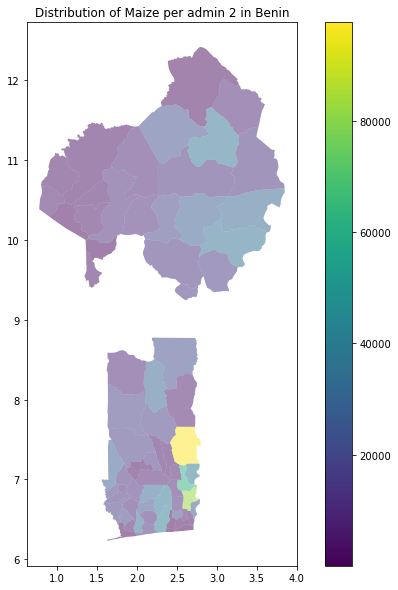

In [52]:
#Maize

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_maize_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Maize"))

# Save plot as figure 
plt.savefig('Maize_Harv_Area_2018.png', bbox_inches='tight')

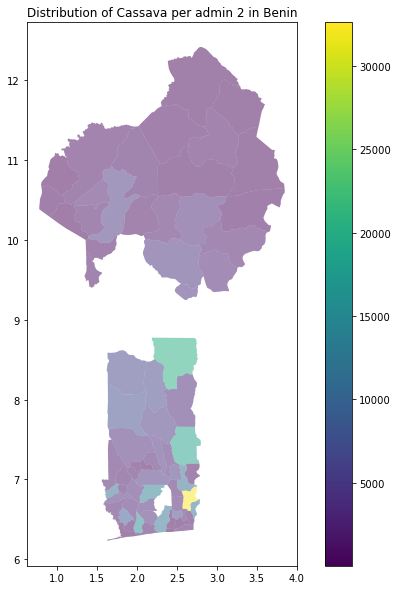

In [53]:
# Cassava

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_cassava_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Cassava"))

# Save plot as figure 
plt.savefig('Cassava_Harv_Area_2018.png', bbox_inches='tight')

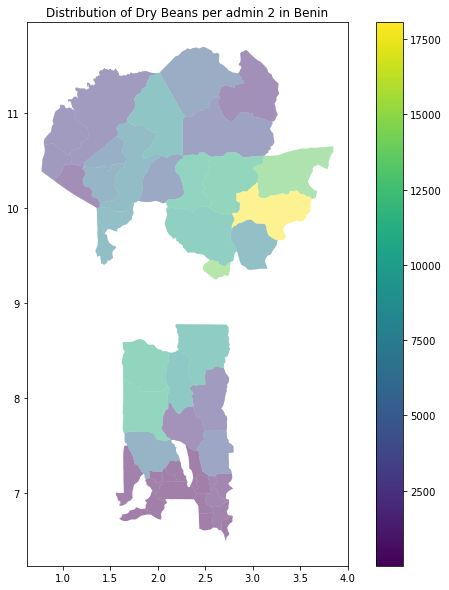

In [54]:
# Yams

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_yams_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Dry Beans"))

# Save plot as figure 
plt.savefig('Yams_Harv_Area_2018.png', bbox_inches='tight')

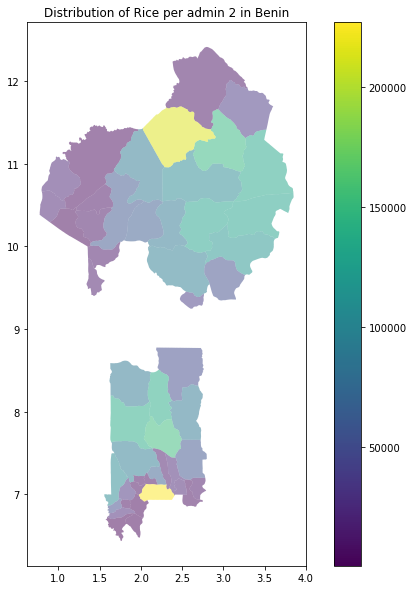

In [55]:
# Cotton

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_cotton_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Rice"))

# Save plot as figure 
plt.savefig('Cotton_Harv_Area_2018.png', bbox_inches='tight')

### Exporting gdfs to shapefiles (shp)

In [56]:
# Define output path
#path = r"N:\Agrodem\Downscaling\Output_Data\Crop_Maps"
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps"

#Maize
admin_2_maize_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_Maize_2018_admin2")))

#Cassava
admin_2_cassava_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_Cassava_2018_admin2")))

#Dry beans
admin_2_yams_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_yams_2018_admin2")))

#Rice paddy
admin_2_cotton_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_cotton_2018_admin2")))